# Team information

|Team-number :| 1|
|:----:|:----:|


|Name|    E-Mail        |matriculation-nr.|
|:----:|:----:|:----:|
|Tamara Scherer| schere21@ads.uni-passau.de|104218|
|Felix Müller| muell518@ads.uni-passau.de|104227|


# 1. Data Import

After labeling the data we now import it from the label-studio plattform. Therefore we used the provided workaround and downloaded the pickle file. In the next step we extract the necessary texts with the corresponding labels out of the whole downloaded data. A dataframe is created with the columns "Text" and "Label" in which the extracted data is saved. 
<p>
As stated in the task formulation we have to focus on at least one ID Stage. So, we implemented a filter to get only the entries with the desired ID Stage. Here we use the second ID Stage with "Question_2_specific" and "Question_2_open". To get a correct index for each entry in the dataframe again, we set a new index and delete the old one.
To be able to work more efficient with the data, we additionally assign an unique ID to each label in the dataframe with the function "setID()". This is especially helpful when we create the neural network in the end, as we can only use integer values as input.  

Necessary packages:
> pickle: This package is used for serializing and de-serializing python object structures which means that any kind of python object is converted into byte streams or vice versa.

> pandas: This package is usually used for data analysis and manipulation. It allows us to create and work with a DataFrame.

**Download labelled tasks**

In [1]:
# import necessary package
import pickle

# import labeled data from downloaded pickle file
with open("Files/tasks3", 'rb') as f:
    tasks = pickle.load(f)

**Extract text with label**

In [2]:
# import necessary package
import pandas as pd

# filter the necessary texts with the corresponding label
df = pd.DataFrame(columns = ['Text', 'Label',])

for i in range(len(tasks)): 
    for j in range(len(tasks[i]['annotations'][0]['result'])): 
        df = df.append({
            'Text' : tasks[i]['annotations'][0]['result'][j]['value']['text'],
            'Label' : tasks[i]['annotations'][0]['result'][j]['value']['labels']
                        }, ignore_index = True)
df

,Text,Label
0,Good afternoon and thanks a lot for taking my ...,[QID_1]
1,Good afternoon and thanks a lot for taking my...,[Question_1_Company_specific]
2,Good afternoon and thanks a lot for taking my ...,[Question_2_specific]
3,Good afternoon and thanks a lot for taking my ...,[Question_3_neutral]
4,"No, I think that as it relates to the one, I t...",[AID_1]
...,...,...
11289,One of the areas obviously which has been a st...,[Question_3_neutral]
11290,"Well, let's start with the first part of your ...",[AID_1]
11291,"Well, let's start with the first part of your ...",[Answer_1_specific]
11292,"Well, let's start with the first part of your ...",[Answer_2_positive]


**Filter one ID Stage (e.g. Question_2_XX)**

In [3]:
# choose ID stage
# we use Question_2_specific and Question_2_open

df = df.query("Label in (['Question_2_specific'], ['Question_2_open'])")

# set new index
df = df.reset_index()
# delete old indices
df.pop('index')

df

,Text,Label
0,Good afternoon and thanks a lot for taking my ...,[Question_2_specific]
1,"Okay, that's very helpful. And then on your gr...",[Question_2_specific]
2,"Hi Richard. So, on gross margin, it looked pr...",[Question_2_specific]
3,And the core-on-core was pretty normal for you...,[Question_2_specific]
4,Okay. And my follow-up is on the EBIT dollar ...,[Question_2_specific]
...,...,...
1306,Hi. This is Mark for Pat. Thank you so much fo...,[Question_2_specific]
1307,Yes. I'm just wondering if you could talk a li...,[Question_2_specific]
1308,"Hi, thank you. Congrats on the quarter. Just a...",[Question_2_specific]
1309,Thanks for squeezing me in guys. This question...,[Question_2_open]


**Assign unique ID for the Labels**

In [4]:
def setID(row):
    if row['Label'] == ['Question_2_specific']:
        return 0
    elif row['Label'] == ['Question_2_open']:
        return 1

# call function and write results in a new column of the dataframe
df['LabelNumber'] = df.apply(
    lambda row: setID(row), axis=1)

df

,Text,Label,LabelNumber
0,Good afternoon and thanks a lot for taking my ...,[Question_2_specific],0
1,"Okay, that's very helpful. And then on your gr...",[Question_2_specific],0
2,"Hi Richard. So, on gross margin, it looked pr...",[Question_2_specific],0
3,And the core-on-core was pretty normal for you...,[Question_2_specific],0
4,Okay. And my follow-up is on the EBIT dollar ...,[Question_2_specific],0
...,...,...,...
1306,Hi. This is Mark for Pat. Thank you so much fo...,[Question_2_specific],0
1307,Yes. I'm just wondering if you could talk a li...,[Question_2_specific],0
1308,"Hi, thank you. Congrats on the quarter. Just a...",[Question_2_specific],0
1309,Thanks for squeezing me in guys. This question...,[Question_2_open],1


# 2. Preprocessing

Now we implement different steps to preprocess the downloaded data. Therefore we have to make some imports first. 

Necessary Packages:
> re: This package can be used to work with Regular Expressions. Here it is used remove the numbers in the text.

> string: This package is necessary for common string operations. Here it is used to remove the punctuation in the text.

> nltk: Natural Language Toolkit is a package which is used for Natural Language Processing. Here it is used for stemming, lemmatization, tokenization and the removal of stopwords.

Further Imports:
> For Stemmer: The module "nltk.stem.snowball" provides a port of the Snowball stemmers. The word stemmer is based on the original Porter stemming algorithm for suffix stripping. In this case it is used for the English language.

> For Stopwords: Here the English stopwords are imported from the "nltk.corpus" package. It includes words which does not add much meaning to a sentence and are not important for further text analysis.

> For Tokenization: The word_tokenize module is imported from the nltk library for tokenization.

> For Lemmatizer: The "WordNetLemmatizer" module as well as "pos_tag" is imported here. Therefore the system requires some further downloads.

In the next step we start with the preprocessing. Therefore, we implemented a function called "do_preprocessing" with text that has to be preprocessed as input. Furthermore, it is possible to set two boolean values to specify if the removal of stopwords and the stemming should be executed. 
Within the function we implemented the following steps:
1. Removal of Numbers: delete all numbers, e.g. 1, 2 of the text
2. Lowercasing: convert the text into the same casing, so that the different versions of the word can be treated as one
3. Stemming: process to reduce the words to their root forms, but the stem itself may not be a valid word in the language (here we use the PorterStemmer)
4. Stopwords Removal: stopwords are trivial words which appear very frequently in the text without adding much valuable information and therefore not necessary for the further analysis
5. Removing Punctuations: the punctuation does not add any value, so it is not necessary or helpful for the analysis and can therefore be deleted as well
6. Removing Extra Whitespaces: additional whitespaces do not add any value to the data and just increase the text size, so they can be deleted as well
<p>
For Lemmatization we implemented another function "do_lemmatization" as it is necessary to do a tokenization first.

1. Tokenization: process of splitting the text into pieces called tokens (here the tokens are the single words)
2. Lemmatization: This can be done instead of stemming. Lemmatization is also a process to convert the word to its base form. Before the text is lemmatized a POS tagging is necessary to tag the tokens as noun, verb, adverb or adjective. As it causes noticeable improvement we implement the lemmatization in addition to the already implemented preprocessing.
<p>
Finally we use the resulting tokens to create a dictionary which is necessary for the following steps as for building the neural network the column size of the training and test dataset have to be identical. This can be ensured by using this dictionary. To be able to execute the next implementations it is necessary to convert the tokens back to normal strings.

**Necessary Imports**

In [5]:
# necessary imports for preprocessing steps

# import necessary packages
import re
import string
import nltk

# import a stemmer for english words
snowStem = nltk.stem.SnowballStemmer('english')

# import stopwords
from nltk.corpus import stopwords
nltk.download('stopwords')
en_stopwords = stopwords.words('english')

# import for tokenization
from nltk import word_tokenize
nltk.download('punkt')

# import for lemmatizer
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ts23\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ts23\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\ts23\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ts23\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\ts23\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

**Preprocessing of the data**

In [6]:
# function that includes all preprocessing steps

def do_preprocessing(text_to_clean, remove_stopwords = True, stemming = True):
    # remove numbers 
    text_to_clean = re.sub(r'\d+', '', text_to_clean)
    # transform text to lower case
    text_to_clean = text_to_clean.lower()

    if stemming:
      # stemming
      text_to_clean = snowStem.stem(text_to_clean)
    
    if remove_stopwords:
        # remove stop words
        text_to_clean = ' '.join([w for w in text_to_clean.split() if not(w in en_stopwords)])

    # remove punctuation
    text_to_clean = text_to_clean.translate(str.maketrans('','', string.punctuation))
    # remove leading and ending white spaces
    text_to_clean = text_to_clean.strip()
    
    return text_to_clean


# call function and write results in new column of the dataframe
df.loc[:, 'CleanText'] = df['Text'].apply(
    lambda x: do_preprocessing(x, True, True))

df

,Text,Label,LabelNumber,CleanText
0,Good afternoon and thanks a lot for taking my ...,[Question_2_specific],0,good afternoon thanks lot taking question so r...
1,"Okay, that's very helpful. And then on your gr...",[Question_2_specific],0,okay thats helpful growth china surpass expect...
2,"Hi Richard. So, on gross margin, it looked pr...",[Question_2_specific],0,hi richard so gross margin looked pretty solid...
3,And the core-on-core was pretty normal for you...,[Question_2_specific],0,coreoncore pretty normal well
4,Okay. And my follow-up is on the EBIT dollar ...,[Question_2_specific],0,okay followup ebit dollar growth looked like c...
...,...,...,...,...
1306,Hi. This is Mark for Pat. Thank you so much fo...,[Question_2_specific],0,hi mark pat thank much taking question could t...
1307,Yes. I'm just wondering if you could talk a li...,[Question_2_specific],0,yes im wondering could talk little bit custome...
1308,"Hi, thank you. Congrats on the quarter. Just a...",[Question_2_specific],0,hi thank you congrats quarter followup toms qu...
1309,Thanks for squeezing me in guys. This question...,[Question_2_open],1,thanks squeezing guys question you john know g...


**Lemmatization**

In [7]:
# function for lemmatization using POS Tagging
def do_lemmatization(text):
    
  text = word_tokenize(text)
  
  result=[]
  wordnet = WordNetLemmatizer()
  for token,tag in pos_tag(text):
        pos=tag[0].lower()
        
        if pos not in ['a', 'r', 'n', 'v']:
            pos='n'
            
        result.append(wordnet.lemmatize(token,pos))

  return result

# call function
df['CleanText'] = df['CleanText'].apply(
    lambda x: do_lemmatization(x))

df

,Text,Label,LabelNumber,CleanText
0,Good afternoon and thanks a lot for taking my ...,[Question_2_specific],0,"[good, afternoon, thanks, lot, take, question,..."
1,"Okay, that's very helpful. And then on your gr...",[Question_2_specific],0,"[okay, thats, helpful, growth, china, surpass,..."
2,"Hi Richard. So, on gross margin, it looked pr...",[Question_2_specific],0,"[hi, richard, so, gross, margin, look, pretty,..."
3,And the core-on-core was pretty normal for you...,[Question_2_specific],0,"[coreoncore, pretty, normal, well]"
4,Okay. And my follow-up is on the EBIT dollar ...,[Question_2_specific],0,"[okay, followup, ebit, dollar, growth, look, l..."
...,...,...,...,...
1306,Hi. This is Mark for Pat. Thank you so much fo...,[Question_2_specific],0,"[hi, mark, pat, thank, much, take, question, c..."
1307,Yes. I'm just wondering if you could talk a li...,[Question_2_specific],0,"[yes, im, wondering, could, talk, little, bit,..."
1308,"Hi, thank you. Congrats on the quarter. Just a...",[Question_2_specific],0,"[hi, thank, you, congrats, quarter, followup, ..."
1309,Thanks for squeezing me in guys. This question...,[Question_2_open],1,"[thanks, squeeze, guy, question, you, john, kn..."


**Create dictionary**

In [8]:
from gensim import corpora

# generate the gensim dictionary
dct = corpora.dictionary.Dictionary(df['CleanText']).values()

**Convert tokens to strings**

In [9]:
# convert tokens back to strings for further processing
whitespace = " "
df['CleanText'] = df['CleanText'].apply(
    lambda x: whitespace.join(x))

df

,Text,Label,LabelNumber,CleanText
0,Good afternoon and thanks a lot for taking my ...,[Question_2_specific],0,good afternoon thanks lot take question so rec...
1,"Okay, that's very helpful. And then on your gr...",[Question_2_specific],0,okay thats helpful growth china surpass expect...
2,"Hi Richard. So, on gross margin, it looked pr...",[Question_2_specific],0,hi richard so gross margin look pretty solid w...
3,And the core-on-core was pretty normal for you...,[Question_2_specific],0,coreoncore pretty normal well
4,Okay. And my follow-up is on the EBIT dollar ...,[Question_2_specific],0,okay followup ebit dollar growth look like com...
...,...,...,...,...
1306,Hi. This is Mark for Pat. Thank you so much fo...,[Question_2_specific],0,hi mark pat thank much take question could tal...
1307,Yes. I'm just wondering if you could talk a li...,[Question_2_specific],0,yes im wondering could talk little bit custome...
1308,"Hi, thank you. Congrats on the quarter. Just a...",[Question_2_specific],0,hi thank you congrats quarter followup tom que...
1309,Thanks for squeezing me in guys. This question...,[Question_2_open],1,thanks squeeze guy question you john know guy ...


# 3. Split of training and test dataset

For the neural network which we build later on, it is necessary to split the available data in a training and a test dataset. We therefore use the 70/30-approach which means that 70% of the data is used for training and 30% of the data is used for testing. 
We do this split already in this step to ensure that there are no dependencies between training and test dataset in the end.
As it does not matter in this case in which order the dataset is splitted we select random indices to get a better mix of the to different label numbers.

Necessary package:
> random: This module implements pseudo-random number generators for various distributions. Here we use it to select random indices for splitting the dataset.

In [10]:
# import necessary package
import random

# training fraction of 70%
train_size = int(0.70 * len(df))

# select random index numbers and split the data accordingly
random.seed(42)
train_select = random.sample(list(df.index), k = train_size)
train_idx = [i for i in list(df.index) if i in train_select]
test_idx = [i for i in list(df.index) if not(i in train_select)]
data_train = df.iloc[train_idx, :]
data_test = df.iloc[test_idx, :]

# 4.1 Frequency Method: Bag-of-Words (BOW)

In this approach the number of terms per document are counted. As we have a big corpora in this case, the resulting document-term matrix is a sparse matrix which means that it has many zeros and only a few non-zero entries.
The method "CountVectorizer()" converts a collection of text documents to a matrix of token counts. The result out of this is a sparse representation of the counts which then have to be transformed into an array. Finally, this array is converted in a DataFrame. 
As already mentioned before, we have created a dictionary out of all the existing tokens after the preprocessing. This dictionary can now be used as input for the CountVectorizer() to get BOW-matrices with the same amount of columns.
<p>
Necessary Package: 

> sklearn.feature_extraction.text.CountVectorizer: Used to convert a collection of text documents to a matrix of token counts. It produces a sparse representation of the counts.

In [11]:
from sklearn.feature_extraction.text import CountVectorizer

def do_bow(data):
    count_vec = CountVectorizer(vocabulary = dct)

    bow = count_vec.fit_transform(data['CleanText'])
    bow_matrix = pd.DataFrame(data = bow.toarray(), columns = count_vec.get_feature_names_out())

    # uncomment if we want to see the results
    # display(bow_matrix)
    
    return(bow_matrix)

# call function
train_bow_matrix = do_bow(data_train)
test_bow_matrix = do_bow(data_test)

# 4.2 Frequency Method: TF-IDF

Another raw frequency-based approach is TF-IDF (= term-frequency inverse-docmument-frequency). Instead of using the absolute term frequencies, we use weighted frequencies for this method.
It is working very similar to the implementation of BOW. For this method the "TfidfVectorizer()" can be used which has again the parameter vocabulary which we set to the created dictionary. The TfidfVectorizer converts a collection of raw documents to a matrix of TF-IDF features. We again get a sparse matrix which we then transform into an array and pass it into a DataFrame which is then given as output of the function.
<p>
Necessary package: 

> sklearn.feature_extraction.text.TfidfVectorizer: used to transform a count matrix to a normalized tf or tf-idf representation.

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

def do_tfidf(data):
    tfidf_vec = TfidfVectorizer(vocabulary = dct)

    tfidf = tfidf_vec.fit_transform(data['CleanText'])
    tfidf_matrix = pd.DataFrame(data = tfidf.toarray(), columns = tfidf_vec.get_feature_names_out())

    # uncomment if we want to see the results
    # display(tfidf_matrix)
    
    return(tfidf_matrix)

# call function
train_tfidf_matrix = do_tfidf(data_train)
test_tfidf_matrix = do_tfidf(data_test)

# 5. Topic Method: LSA

LSA (= latent semantic analysis) is one representative of topic-based approaches. It is a mathematical decomposition technique using raw frequency matrices. As already mentioned, BOW or TF-IDF matrices can be very spare and high dimensional. LSA is facing this problem by reducing the dimensionality.
Therefore, the resulting matrix of BOW or TF-IDF is necessary which we already get as output of the corresponding functions. So, we use for example the tf-idf-matrix as input for this function. Then we set the number of topics and apply singular value decomposition to the matrix which can be done for example by the function "svds".
<p>
Necessary Package:

> scipy.sparse.linalg.svds: It is used to make a partial singular value decomposition of a sparse matrix.

In [13]:
from scipy.sparse.linalg import svds

def do_lsa(data):
    num_components = 10
    q, s, p = svds(data, k = num_components)

    lsa_doc_matrix = pd.DataFrame(data=q)

    # uncomment if we want to see the results
    # display(lsa_doc_matrix)

    return(lsa_doc_matrix)

# call function
train_lsa_matrix = do_lsa(train_tfidf_matrix)
test_lsa_matrix = do_lsa(test_tfidf_matrix)

# 6. Word Embedding Method: Doc2Vec

With the Doc2Vec method it is possible to derive document vectors. As opposite to Word2Vec it is used to create a vectorized representation of a group of words taken collectively as a single unit.
First of all we have to train the model. In order to do this we need the tagged document which can be created by using "models.doc2vec.TaggedDocument()". In the next step we initialise the model, build the vocabulary and train the Doc2Vec model. Finally, we can use the model.infer_vector() to analyse the output and save the matrix as a DataFrame.

<p>
Necessary Package:

> gensim: Used for topic modelling, document indexing and similarity retrieval with large corpora. The target audience is the natural language processing and information retrieval community.

> gensim.models.doc2vec.Doc2Vec: Necessary to build the Doc2Vec model.

In [14]:
import gensim
from gensim.models.doc2vec import Doc2Vec

def do_doc2vec(data):
    tagged_documents = []
    sentences = [text.split() for text in data['CleanText']]
    doc2vec_alldocs = []

    # train the doc2vec
    for i, doc in enumerate(sentences):
        tagged_documents.append(gensim.models.doc2vec.TaggedDocument(doc, [i]))

    # initialize the model
    d2v = Doc2Vec(vector_size=50, min_count=2, epochs=40)
    # build the vocabulary
    d2v.build_vocab(tagged_documents)

    # train the doc2vec model
    d2v.train(tagged_documents, total_examples=d2v.corpus_count, epochs=d2v.epochs)

    # create Doc2Vec-matrix out of all documents and pass it into a DataFrame
    for i in range(len(tagged_documents)):
        doc2vec_alldocs.append(d2v.infer_vector(tagged_documents[i].words))
    doc2vec_alldocs_matrix = pd.DataFrame(doc2vec_alldocs)

    # uncomment if we want to see the results
    # display(doc2vec_alldocs_matrix)
    
    return(doc2vec_alldocs_matrix)

# call function
train_doc2vec_matrix = do_doc2vec(data_train) 
test_doc2vec_matrix = do_doc2vec(data_test)

# 7. Generating a Neural Network

In the last step we have to create a neural network to generate a target model that predicts the correct label for a text. Therefore we first have to convert the matrices of BOW and TF-IDF to an array to successfully run the further implementation. Then we implemented the function "build_nn" where we define the neural network. Here we have chosen a simple FNN. Then the compilation is done where we define the loss function ("binary_crossentropy") which is supposed to be minimized and which optimization method should be used. This cross-entropy loss is for binary (0 or 1) classification applications. Now we can fit the model. In the end we plot the results using the loss values. <p>
As input for the function we use the prepared dataframe with the preprocessed data and the output of BOW, TF-IDF, LSA and Doc2Vec.


<p>
Necessary Packages:

> tensorflow: Provides various tools for machine learning applications. We need it in the following to generate the neural networks.

> matplotlib.pyplot: It is used for plotting the results.

> numpy: Provides operations on arrays, including mathematical, logical, shape manipulation, sorting, selecting, I/O, basic linear algebra and much more. We use it here to convert the BOW- and TFIDF-matrix to an array which is necessary for the further implementation.

In [15]:
# import necessary packages
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

# convert dataframe in numpy-array
# necessary for further implementation
train_bow_matrix = np.asarray(train_bow_matrix)
test_bow_matrix = np.asarray(test_bow_matrix)
train_tfidf_matrix = np.asarray(train_tfidf_matrix)
test_tfidf_matrix = np.asarray(test_tfidf_matrix)


# define function to create a neural network
def build_nn(train_X, train_y, test_X, test_y):

    # define neural network
    neural_network = tf.keras.Sequential([ # initialize the recurrent neural network by initializing an object from TensorFlow’s Sequential class
        tf.keras.layers.InputLayer(input_shape = (train_X.shape[1]))
    ])
    neural_network.add(tf.keras.layers.Dense(100, activation= 'selu')) # add a layer with the activation function selu
    neural_network.add(tf.keras.layers.Dropout(0.25)) # Dropout regularization to avoid overfitting 
    neural_network.add(tf.keras.layers.Dense(1, activation = 'sigmoid')) # define one output layer 

    # compilation
    neural_network.compile(loss = 'binary_crossentropy', optimizer = 'sgd',  metrics = ['accuracy', tf.keras.metrics.Recall()])

    # a summary for all parameters which need to be estimated
    neural_network.summary()

    # we fit the model, epochs is the number of steps which are repeated using gradient descent
    history = neural_network.fit(train_X, train_y, epochs = 100, validation_data = (test_X, test_y))
    plt.plot(history.history['loss'], label = 'training'), plt.plot(history.history['val_loss'], label = 'test'), plt.legend(loc='lower left'), plt.show()

    return neural_network

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               448100    
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 448,201
Trainable params: 448,201
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
29/29 [==============================] - 2s 25ms/step - loss: 0.6889 - accuracy: 0.5333 - recall: 0.2929 - val_loss: 0.6779 - val_accuracy: 0.5964 - val_recall: 0.0795
Epoch 2/100
29/29 [==============================] - 0s 8ms/step - loss: 0.6621 - accuracy: 0.6183 - recall: 0.0769 - val_loss: 0.6735

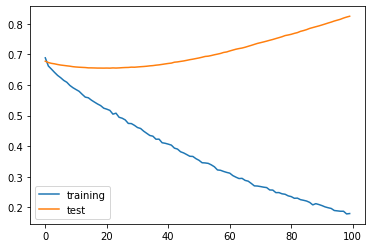

In [16]:
nn_bow = build_nn(train_bow_matrix, data_train['LabelNumber'], test_bow_matrix, data_test['LabelNumber'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 100)               448100    
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
Total params: 448,201
Trainable params: 448,201
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
29/29 [==============================] - 2s 28ms/step - loss: 0.6834 - accuracy: 0.6107 - recall_1: 0.1746 - val_loss: 0.6797 - val_accuracy: 0.6142 - val_recall_1: 0.0000e+00
Epoch 2/100
29/29 [==============================] - 0s 8ms/step - loss: 0.6710 - accuracy: 0.6314 - recall_1: 0.0000e+00 - 

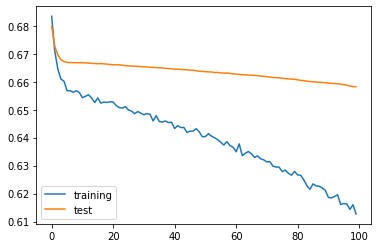

In [17]:
nn_tfidf = build_nn(train_tfidf_matrix, data_train['LabelNumber'], test_tfidf_matrix, data_test['LabelNumber'])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 100)               1100      
                                                                 
 dropout_2 (Dropout)         (None, 100)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 101       
                                                                 
Total params: 1,201
Trainable params: 1,201
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
29/29 [==============================] - 2s 26ms/step - loss: 0.6865 - accuracy: 0.6009 - recall_2: 0.0651 - val_loss: 0.6819 - val_accuracy: 0.6142 - val_recall_2: 0.0000e+00
Epoch 2/100
29/29 [==============================] - 0s 11ms/step - loss: 0.6743 - accuracy: 0.6325 - recall_2: 0.0030 - val_los

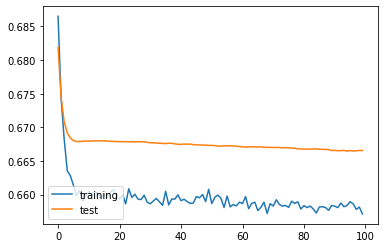

In [18]:
nn_lsa = build_nn(train_lsa_matrix, data_train['LabelNumber'], test_lsa_matrix, data_test['LabelNumber'])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 100)               5100      
                                                                 
 dropout_3 (Dropout)         (None, 100)               0         
                                                                 
 dense_7 (Dense)             (None, 1)                 101       
                                                                 
Total params: 5,201
Trainable params: 5,201
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
29/29 [==============================] - 3s 43ms/step - loss: 0.6935 - accuracy: 0.5387 - recall_3: 0.2337 - val_loss: 0.6812 - val_accuracy: 0.6193 - val_recall_3: 0.0331
Epoch 2/100
29/29 [==============================] - 0s 11ms/step - loss: 0.6712 - accuracy: 0.5954 - recall_3: 0.1598 - val_loss: 0

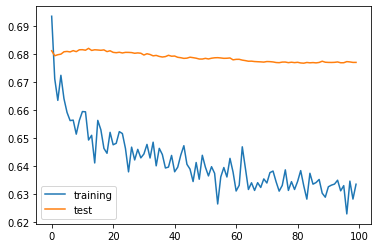

In [19]:
nn_doc2vec = build_nn(train_doc2vec_matrix, data_train['LabelNumber'], test_doc2vec_matrix, data_test['LabelNumber'])

After creating the different neural networks we want to have a look at the confusion matrices for the train and test data. This is done in the function "create_confmat" which is called for BOW, TF-IDF, LSA and Doc2Vec each. Then we take a look at the distribution of the two different Label-IDs (0 and 1). As the printed plot shows, the number of entries with LabelNumber = 0 is with more than 800 nearly two times higher than the number of entries with LabelNumber = 1. So the both classes are rather unbalanced and consequently the network learns more about "Question_2_specific" than about "Question_2_open". <p>
This is the reason why we decided to do an upsampling of the data which may cause a possible improvement. This means that we create artificial observations for LabelNumber = 1 which are then included in addition during the training of the network. We use the output of this upsamling-function to build again the neural network for each of the methods and plot the confusion matrix again. The results of all this will be discussed in the following chapter.

<p>
Necessary Packages:

> seaborn: This is a Python data visualization library based on matplotlib. It provides a high-level interface for drawing attractive and informative statistical graphics. Here we need it to output the heat matrix of the confusion matrix.

> sklearn.matrix.confusion_matrix: We use this package to compute the confusion matrix to evaluate the accuracy of the classification.

> matplotlib.pylab: PyLab is a procedural interface to the Matplotlib object-oriented plotting library. In the following it is used to plot the corresponding confusion matrices as well as the histogram of the distribution.

> imblearn.over_sampling.SMOTENC: SMOTENC (= Synthetic Minority Over-sampling Technique for Nominal and Continuous) is used to perform upsamling for datasets containing numerical and categorical features but not categorical features only.

In [20]:
import seaborn as sn
from sklearn.metrics import confusion_matrix
import matplotlib.pylab as plt

def create_confmat(nn, train_X, test_X):
    neural_network = nn
    
    # print confusion matrix
    # predictions are 1 if the predicted proability for class 1 is higher than 0.5
    fig, axs = plt.subplots(1, 2, figsize=(18, 8))

    train_cm = confusion_matrix(data_train['LabelNumber'], (neural_network.predict(train_X) > 0.50).ravel() * 1)
    sn.heatmap(train_cm, annot = True, cmap='Greens', ax = axs[0])

    axs[0].set_xlabel('Predictions')
    axs[0].set_ylabel('True Labels')
    axs[0].set_title('Training data')

    test_cm = confusion_matrix(data_test['LabelNumber'], (neural_network.predict(test_X) > 0.50).ravel() * 1)
    sn.heatmap(test_cm, annot = True, cmap='Greens', ax = axs[1])

    axs[1].set_xlabel('Predictions')
    axs[1].set_ylabel('True Labels')
    axs[1].set_title('Test data')

plt.show()

BOW


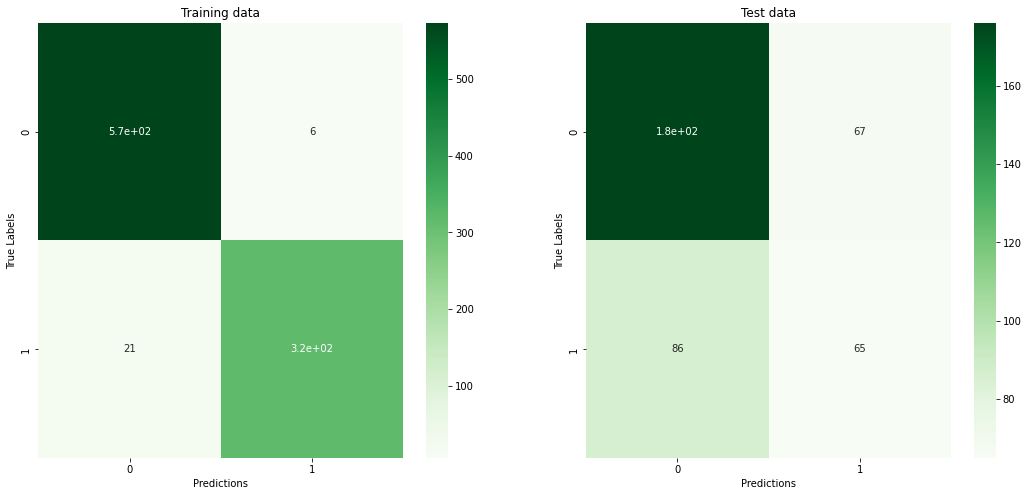

In [21]:
print("BOW")
create_confmat(nn_bow, train_bow_matrix, test_bow_matrix)

TF-IDF


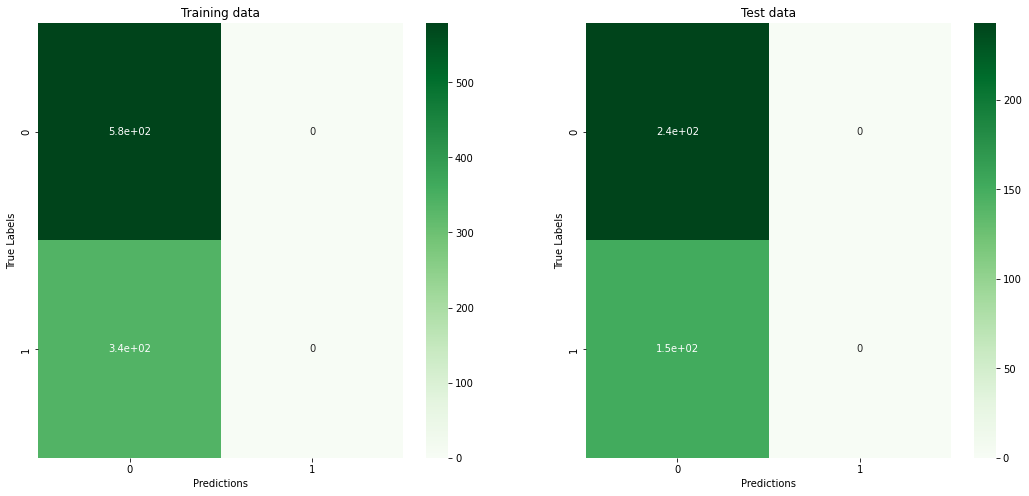

In [22]:
print("TF-IDF")
create_confmat(nn_tfidf, train_tfidf_matrix, test_tfidf_matrix)

LSA


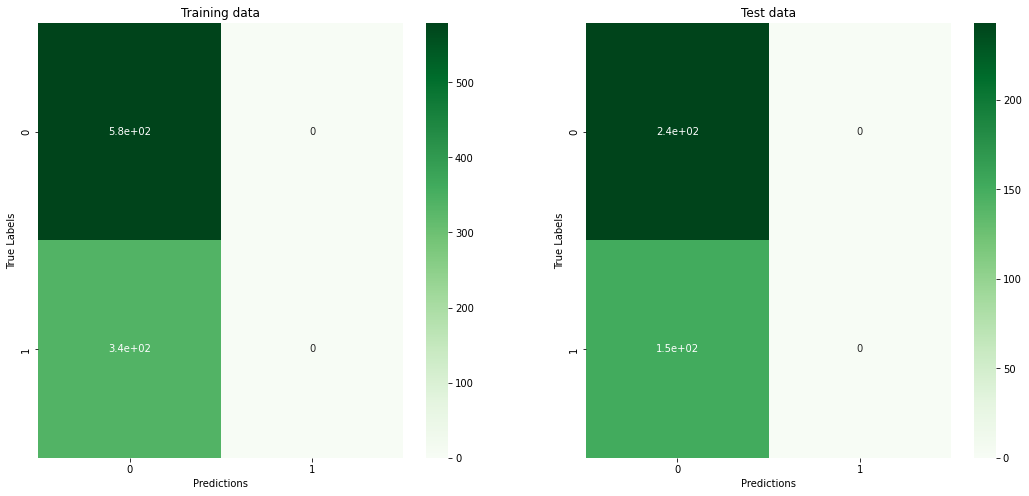

In [23]:
print("LSA")
create_confmat(nn_lsa, train_lsa_matrix, test_lsa_matrix)

DOC2VEC


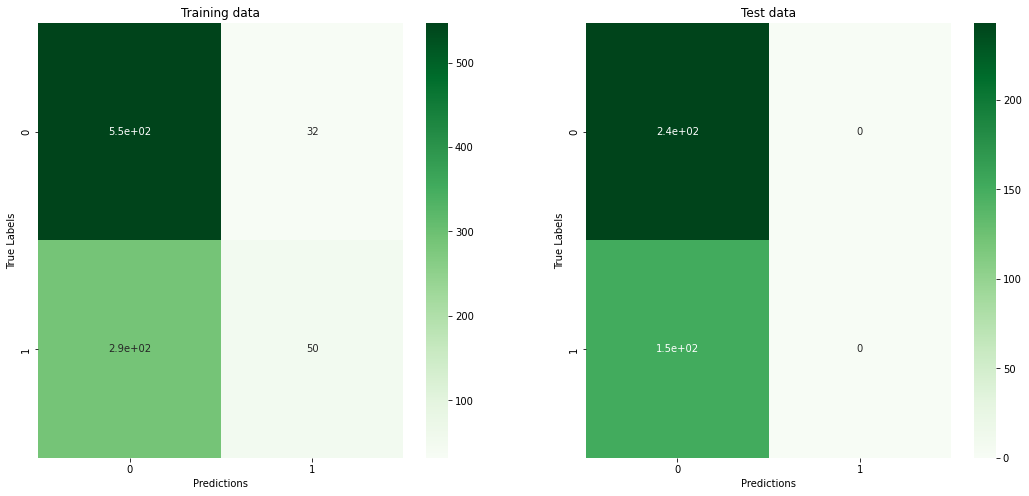

In [24]:
print("DOC2VEC")
create_confmat(nn_doc2vec, train_doc2vec_matrix, test_doc2vec_matrix)

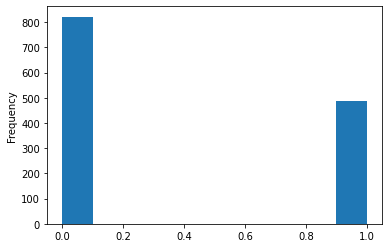

In [25]:
# distribution of the two different Label-IDs
df['LabelNumber'].plot(kind = 'hist')
plt.show() 

In [26]:
from imblearn.over_sampling import SMOTENC

# use SMOTENC which is capable for mixed features (numerical and categorical)
# synthetic observations for categorical features are chosen by majority categories per feature
# SMOTENC needs to know which features are categorical

def upsampling(train_X):
    smt = SMOTENC(categorical_features = [df.dtypes==object], sampling_strategy = 1)
    X_train_sm, y_train_sm = smt.fit_resample(train_X, data_train['LabelNumber'])
    return X_train_sm, y_train_sm


# call function
X_train_sm_bow, y_train_sm_bow = upsampling(train_bow_matrix)
X_train_sm_tfidf, y_train_sm_tfidf = upsampling(train_tfidf_matrix)
X_train_sm_lsa, y_train_sm_lsa = upsampling(train_lsa_matrix)
X_train_sm_doc2vec, y_train_sm_doc2vec = upsampling(train_doc2vec_matrix)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 100)               448100    
                                                                 
 dropout_4 (Dropout)         (None, 100)               0         
                                                                 
 dense_9 (Dense)             (None, 1)                 101       
                                                                 
Total params: 448,201
Trainable params: 448,201
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
37/37 [==============================] - 3s 37ms/step - loss: 0.6902 - accuracy: 0.5155 - recall_4: 0.4646 - val_loss: 0.6945 - val_accuracy: 0.5127 - val_recall_4: 0.3775
Epoch 2/100
37/37 [==============================] - 1s 14ms/step - loss: 0.6763 - accuracy: 0.5630 - recall_4: 0.5302 - val_los

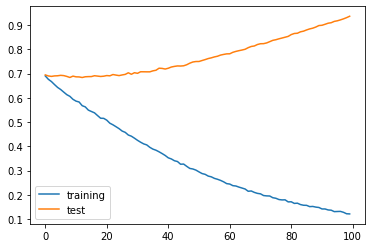

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 100)               448100    
                                                                 
 dropout_5 (Dropout)         (None, 100)               0         
                                                                 
 dense_11 (Dense)            (None, 1)                 101       
                                                                 
Total params: 448,201
Trainable params: 448,201
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
37/37 [==============================] - 4s 37ms/step - loss: 0.6939 - accuracy: 0.4965 - recall_5: 0.4249 - val_loss: 0.6948 - val_accuracy: 0.4492 - val_recall_5: 0.5960
Epoch 2/100
37/37 [==============================] - 1s 14ms/step - loss: 0.6933 - accuracy: 0.5155 - recall_5: 0.6563 - val_los

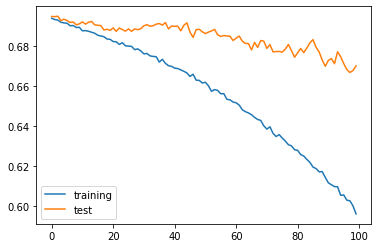

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 100)               1100      
                                                                 
 dropout_6 (Dropout)         (None, 100)               0         
                                                                 
 dense_13 (Dense)            (None, 1)                 101       
                                                                 
Total params: 1,201
Trainable params: 1,201
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
37/37 [==============================] - 2s 23ms/step - loss: 0.6934 - accuracy: 0.5086 - recall_6: 0.4197 - val_loss: 0.6916 - val_accuracy: 0.5457 - val_recall_6: 0.4901
Epoch 2/100
37/37 [==============================] - 0s 8ms/step - loss: 0.6928 - accuracy: 0.5130 - recall_6: 0.5786 - val_loss: 0.

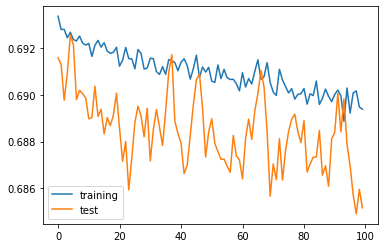

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 100)               5100      
                                                                 
 dropout_7 (Dropout)         (None, 100)               0         
                                                                 
 dense_15 (Dense)            (None, 1)                 101       
                                                                 
Total params: 5,201
Trainable params: 5,201
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
37/37 [==============================] - 3s 33ms/step - loss: 0.7173 - accuracy: 0.5268 - recall_7: 0.6149 - val_loss: 0.7004 - val_accuracy: 0.4746 - val_recall_7: 0.5828
Epoch 2/100
37/37 [==============================] - 0s 9ms/step - loss: 0.7092 - accuracy: 0.5199 - recall_7: 0.5699 - val_loss: 0.

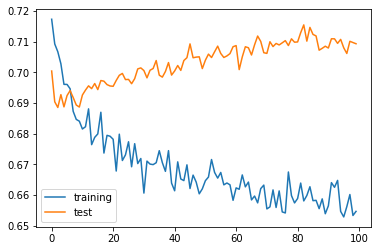

In [27]:
# build again the NN with the new upsampled data
nn_bow_new = build_nn(X_train_sm_bow, y_train_sm_bow, test_bow_matrix, data_test['LabelNumber'])
nn_tfidf_new = build_nn(X_train_sm_tfidf, y_train_sm_tfidf, test_tfidf_matrix, data_test['LabelNumber'])
nn_lsa_new = build_nn(X_train_sm_lsa, y_train_sm_lsa, test_lsa_matrix, data_test['LabelNumber'])
nn_doc2vec_new = build_nn(X_train_sm_doc2vec, y_train_sm_doc2vec, test_doc2vec_matrix, data_test['LabelNumber'])

BOW


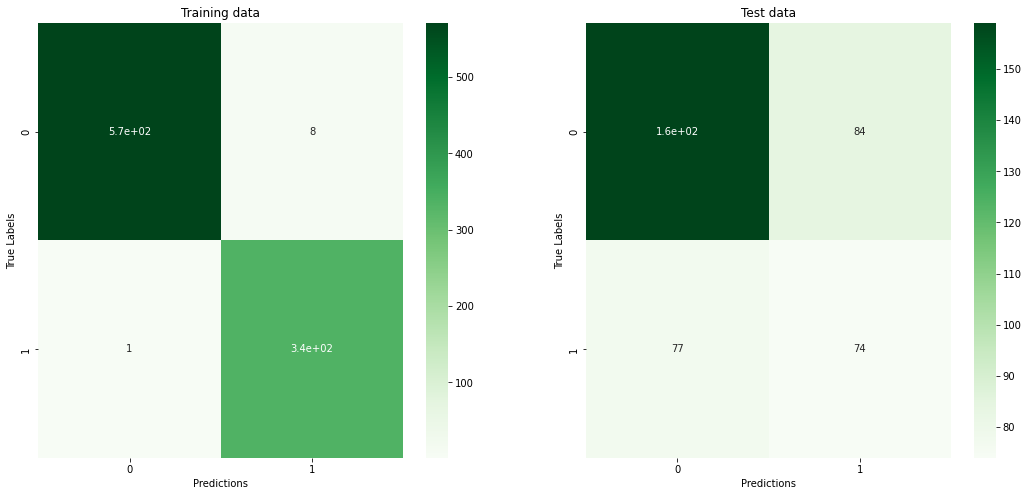

In [28]:
print("BOW")
create_confmat(nn_bow_new, train_bow_matrix, test_bow_matrix)

TF-IDF


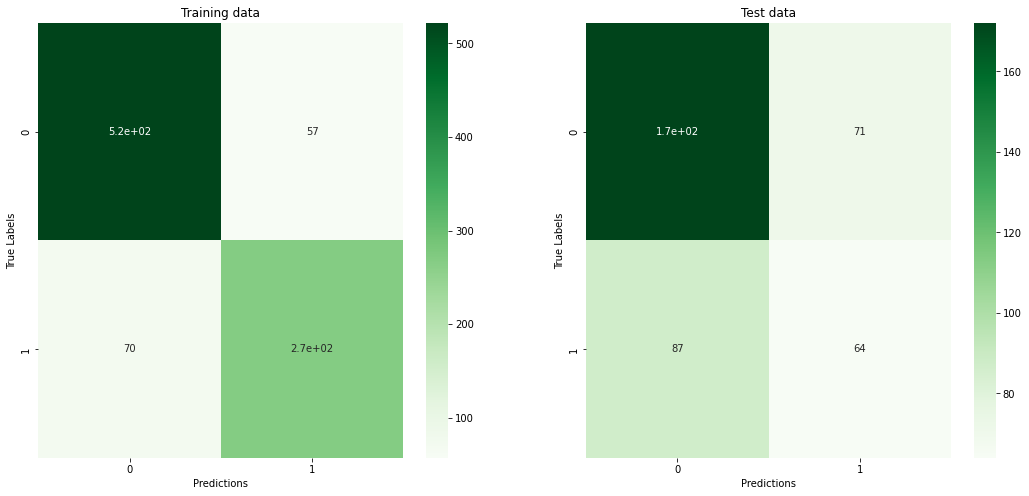

In [29]:
print("TF-IDF")
create_confmat(nn_tfidf_new, train_tfidf_matrix, test_tfidf_matrix)

LSA


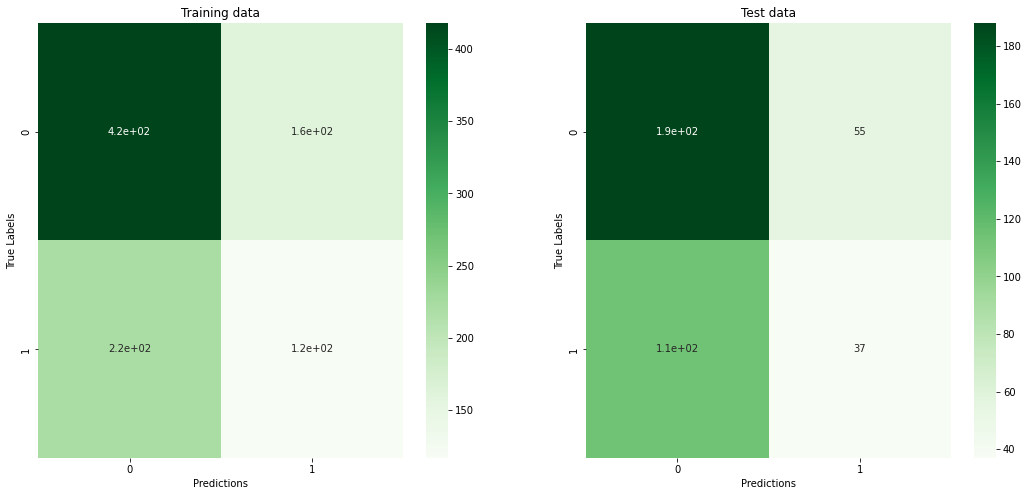

In [30]:
print("LSA")
create_confmat(nn_lsa_new, train_lsa_matrix, test_lsa_matrix)

DOC2VEC


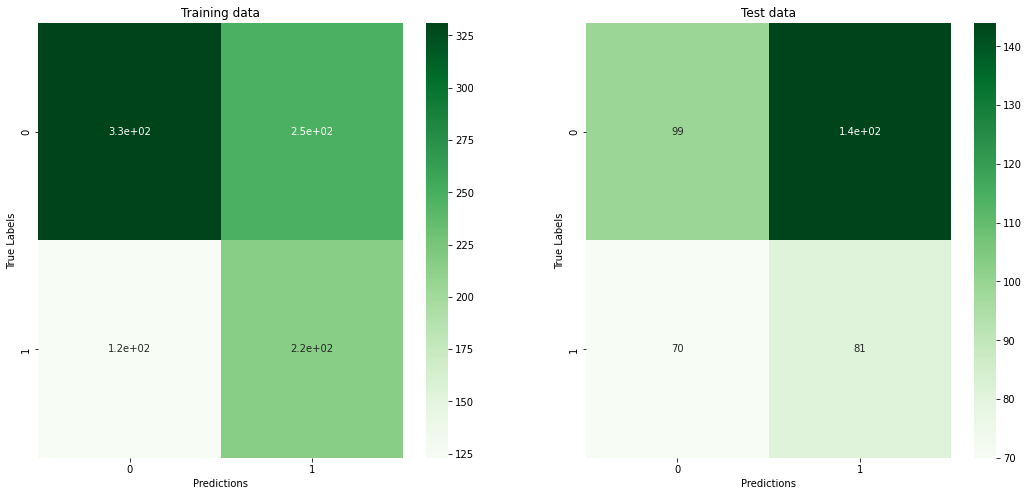

In [31]:
print("DOC2VEC")
create_confmat(nn_doc2vec_new, train_doc2vec_matrix, test_doc2vec_matrix)

# 8. Discussion

In our project we went through several steps. <p>
At first we started with the data import. Here we decided to use the two labels "Question_2_specific" and "Question_2_open". As the task was to focus on only one ID-Stage we implemented a filter right at the beginning for the second ID-Stage. <p>  

In the next step, we performed different preprocessing steps and then split the data into training and test data. Here we made sure that the questions were randomly selected, as otherwise there could be problems when using related passages, as there is an increased chance that the same labels were used. <p>

In the further part, we then focused on 4 different methods that serve as the data basis for the neural networks. Although we are a team of only two students we decided to implement BOW as well as TF-IDF as the implementation of both is pretty similar. <p>

After implementing the methods BOW, TF-IDF, LSA and Doc2Vec in the first step, we then created neural networks for them. 
We found that the BOW method already performs quite well. However, it was noticeable that many values in the confusion matrices are 0. We suspected that this was due to the distribution of the labels (number of Label0 = more than 800 and Label1 = approx. 400), which is very unbalanced. As we already now, unbalanced data can lead to models which do not perform good for the remaining categories which are not over-proportionally represented. In order to solve this problem, we have two different options, namely undersampling/downsampling or oversampling/upsampling the data. Undersampling means to delete observations of the over-represented category where as oversampling means to create artificial non-existing observations for the under-represented category. In this case, we decided to use the second option as the amount of data is already not that high and with deleting data it is reduced again. So by upsampling the data we could solve the problem of unbalanced data and we recognized also a slight improvement for all four methods. <p>

To get a better overview we also calculated and plotted the corresponding confusion matrices which contrasts the actual versus the predicted categories. In this confusion matrix the predictions are 1 if the predicted proability for class 1 is higher than 0.5. After upsampling, we found that in some cases the true positive and false negative values increased and the false positive and true negative values decreased in part, but of course this was not the case for all.

<p>
Nevertheless, the results for BOW and TF-IDF are pretty good. It can be said that BOW and TF-IDF give very good results, as the accuracy for training data is very high (BOW = 99% TF-IDF = 85%). 

<p>

The results for LSA and Doc2Vec, on the other hand, give poor results. It is possible that this results from the lack of semantic context recognition. 
The size of the data could also play a role. The input data is too small to obtain a meaningful representation of the documents. 

Furthermore, we have to take into account that the text was labelled by different people which may cause different results as well as possible human errors. 

In addition to the upsampling of the data, which lead to a slight improvement, there are possibilities for further improvements for example to change the settings of the neural network and do some hyperparameter tuning. We tried to use the Keras Autotuner to improve some parameters such as units, activation function and a dropout option. Since this did not lead to any clearly discernible improvements we decided to stick with the previous function for building the neural network.